In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests as rq
import time

In [2]:
prof_list = []
df_prof = pd.read_csv('./교양_교수.csv', names=['교수'])
df_prof.head()

,교수
0,김제민
1,김홍섭
2,김상연
3,이용식
4,안희봉


In [3]:
df_prof = df_prof.drop_duplicates()

In [4]:
# 교수명 앞 뒤 공백 제거
profs = df_prof['교수'].apply(lambda x : x.strip())

In [5]:
base_url = 'https://everytime.kr'
header = {'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'}
driver = webdriver.Chrome()

In [6]:
# 강의 평가 페이지 접근
driver.get(base_url + '/lecture')

In [8]:
user_id = 'test_id'
user_pw = 'test_pw'
driver.find_element_by_name('userid').send_keys(user_id) # 아이디 입력
driver.find_element_by_name('password').send_keys(user_pw) # 비밀번호 입력
driver.find_element_by_css_selector('p.submit>input').click() # 로그인 버튼 클릭

##### 검색 Example

In [10]:
driver.find_element_by_name('keyword').send_keys("박혁로") # 검색어 입력
driver.find_element_by_name('keyword').send_keys(Keys.RETURN)

In [11]:
html = bs(driver.page_source, 'html.parser')

In [13]:
lectures = html.select('a.lecture') # 교수님의 모든 강의

#### 다음 실행 때는 lxml로 변경

### 교수명으로 강의 크롤링
#### 미개선 사항: 교수님 강의 리스트 중 별점 0이 나오면 다음 교수님으로 넘어가기 때문에 수정 필요

In [185]:
lec_list = []
reviews = []
lec_page = ''

for prof in profs:
    driver.get(base_url + '/lecture')
    driver.find_element_by_name('keyword').send_keys(prof) # 검색어 입력
    driver.find_element_by_name('keyword').send_keys(Keys.RETURN)
    time.sleep(1)
    html = bs(driver.page_source, 'html.parser')
    lectures = html.select('a.lecture')
    
    lec_page = ''
    lec_urls = []
    for lecture in lectures:
        rate = lecture.select_one('a.lecture>p.rate>span.star>span.on')['style']
        if rate == 'width: 0%;':
            break;
        lecture_name = lecture.select_one('h3>p.name').text
        lecture_professor = lecture.select_one('h3>p.professor').text
        lec_urls.append(lecture['href'])
        lec_list.append([lecture_name, lecture_professor, rate])
        
    for lec_url in lec_urls:
        driver.get(base_url + lec_url)
        time.sleep(1)
        lec_page = bs(driver.page_source, 'html.parser')
        lecture_name = lec_page.select_one('div.head>h2').text
        lecture_professor = lec_page.select_one('div.head>p:nth-child(3)>span').text
        lecture_feature = [i.text for i in lec_page.select('div.details span')]
        for review in lec_page.select('div.articles>article'):
            star = review.select_one('span.on')['style']
            review = review.select_one('p.text').text
            reviews.append([lecture_name, lecture_professor, lecture_feature, star, review])

In [187]:
len(lec_list) # 강좌 수

763

In [188]:
len(reviews) # 총 리뷰

7315

In [191]:
reviews[0]

['창작드로잉2',
 '김제민',
 ['없음', '없음', '학점느님', '직접호명', '없음'],
 'width: 100%;',
 '완젼 편하구~과제도없어요~~꿀강~~미대 아니여도 편하게 들을수 잇는강의랍니다']

### pickle로 저장

In [192]:
with open('reviews.txt', 'wb') as f:
    pickle.dump(reviews, f)

In [196]:
df_review = pd.DataFrame(reviews)

### Wordcloud로 띄워보기

In [202]:
from wordcloud import WordCloud

In [203]:
import matplotlib.pyplot as plt

In [257]:
words = ''
for review in df_review[4]:
    words += review + ' '

In [258]:
wordcloud  = WordCloud().generate(words)

In [259]:
wordcloud.words_

{'수업': 1.0,
 '진짜': 0.7707509881422925,
 '그냥': 0.7296442687747036,
 '교수님이': 0.7154150197628458,
 '시험': 0.7114624505928854,
 '시험은': 0.6996047430830039,
 '교수님': 0.6466403162055336,
 '정말': 0.5960474308300395,
 '많이': 0.5557312252964427,
 '너무': 0.45217391304347826,
 '그리고': 0.42371541501976284,
 '과제': 0.39446640316205533,
 '수업은': 0.3865612648221344,
 '과제는': 0.3549407114624506,
 '근데': 0.34782608695652173,
 '학점': 0.3359683794466403,
 '저는': 0.30355731225296445,
 '시험도': 0.3027667984189723,
 '그래도': 0.3019762845849802,
 '강의': 0.30039525691699603,
 '거의': 0.2837944664031621,
 '열심히': 0.28221343873517785,
 '같아요': 0.2648221343873518,
 '수업시간에': 0.25691699604743085,
 '엄청': 0.25612648221343876,
 '수업을': 0.25375494071146243,
 '하지만': 0.25296442687747034,
 '출석': 0.24980237154150198,
 '출석은': 0.22529644268774704,
 '과제도': 0.21818181818181817,
 '매우': 0.21818181818181817,
 '학점은': 0.216600790513834,
 '다른': 0.2150197628458498,
 '하고': 0.20632411067193676,
 '피피티': 0.20553359683794467,
 '조금': 0.2007905138339921,
 '나름': 

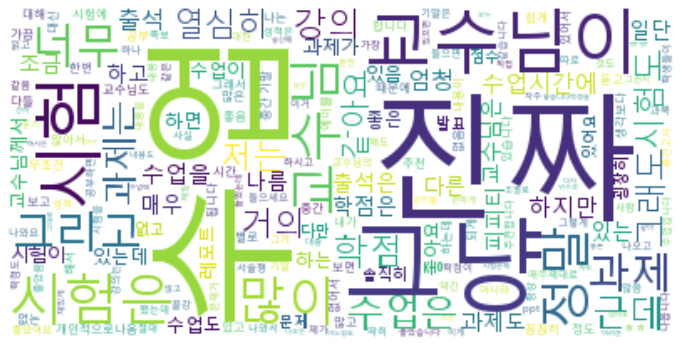

In [219]:
plt.figure(figsize=(12, 12))
wordcloud = WordCloud(
    font_path='/Windows/Fonts/malgun.ttf',
    background_color='white'
).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [230]:
df_review[1].value_counts().head()

홍영식    191
류재한    156
신상은    147
김주용    141
정기화    122
Name: 1, dtype: int64

In [248]:
test_words = ''
for review in df_review[df_review[1]=='홍영식'][4]:
    test_words += review + ' '

In [249]:
wordcloud  = WordCloud().generate(test_words)

In [235]:
wordcloud.words_

{'수업': 1.0,
 '진짜': 0.752913752913753,
 '그냥': 0.7365967365967366,
 '시험은': 0.7094017094017094,
 '교수님이': 0.7055167055167055,
 '시험': 0.703962703962704,
 '교수님': 0.6324786324786325,
 '정말': 0.6083916083916084,
 '많이': 0.560994560994561,
 '너무': 0.4467754467754468,
 '그리고': 0.4226884226884227,
 '과제': 0.41181041181041184,
 '수업은': 0.38694638694638694,
 '과제는': 0.35664335664335667,
 '근데': 0.3504273504273504,
 '학점': 0.33644133644133645,
 '시험도': 0.30924630924630925,
 '그래도': 0.30303030303030304,
 '저는': 0.3014763014763015,
 '강의': 0.2999222999222999,
 '거의': 0.28438228438228436,
 '열심히': 0.2766122766122766,
 '같아요': 0.2618492618492618,
 '엄청': 0.2595182595182595,
 '수업시간에': 0.2571872571872572,
 '출석': 0.25485625485625485,
 '수업을': 0.25252525252525254,
 '하지만': 0.2494172494172494,
 '과제도': 0.236985236985237,
 '출석은': 0.22066822066822067,
 '학점은': 0.21678321678321677,
 '매우': 0.21522921522921523,
 '다른': 0.2128982128982129,
 '하고': 0.2097902097902098,
 '피피티': 0.20357420357420358,
 '일단': 0.19658119658119658,
 '조금': 0.1950

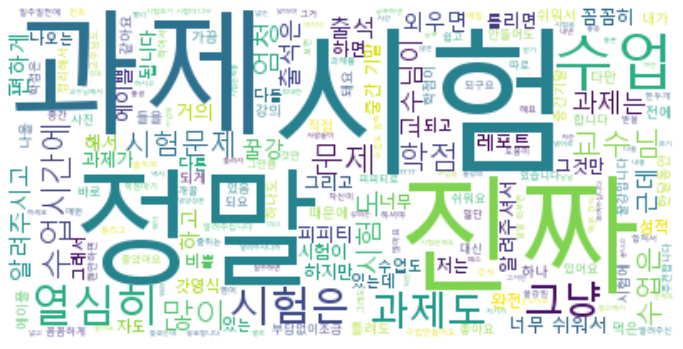

In [251]:
plt.figure(figsize=(12, 12))
wordcloud = WordCloud(
    font_path='/Windows/Fonts/malgun.ttf',
    background_color='white'
).generate(test_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [255]:
from collections import Counter
from konlpy.tag import Twitter
import pytagcloud

### 전컴교수님들로 크롤링

In [274]:
df_prof_ece = pd.read_csv('전컴_전공_교수.csv', names=['교수'])

In [275]:
df_prof_ece = df_prof_ece['교수'].drop_duplicates().apply(lambda x : x.split()[0])

In [279]:
profs_ece = df_prof_ece.values

In [280]:
lec_list = []
reviews = []
lec_page = ''

for prof in profs_ece:
    driver.get(base_url + '/lecture')
    driver.find_element_by_name('keyword').send_keys(prof) # 검색어 입력
    driver.find_element_by_name('keyword').send_keys(Keys.RETURN)
    time.sleep(1)
    html = bs(driver.page_source, 'html.parser')
    lectures = html.select('a.lecture')
    
    lec_page = ''
    lec_urls = []
    for lecture in lectures:
        rate = lecture.select_one('a.lecture>p.rate>span.star>span.on')['style']
        if rate == 'width: 0%;':
            break;
        lecture_name = lecture.select_one('h3>p.name').text
        lecture_professor = lecture.select_one('h3>p.professor').text
        lec_urls.append(lecture['href'])
        lec_list.append([lecture_name, lecture_professor, rate])
        
    for lec_url in lec_urls:
        driver.get(base_url + lec_url)
        time.sleep(1)
        lec_page = bs(driver.page_source, 'html.parser')
        lecture_name = lec_page.select_one('div.head>h2').text
        lecture_professor = lec_page.select_one('div.head>p:nth-child(3)>span').text
        lecture_feature = [i.text for i in lec_page.select('div.details span')]
        for review in lec_page.select('div.articles>article'):
            star = review.select_one('span.on')['style']
            review = review.select_one('p.text').text
            reviews.append([lecture_name, lecture_professor, lecture_feature, star, review])

In [282]:
len(lec_list)

145

In [283]:
len(reviews)

638

In [286]:
df_review = pd.DataFrame(reviews)

In [287]:
ece_words = ''
for review in df_review[4]:
    ece_words += review + ' '

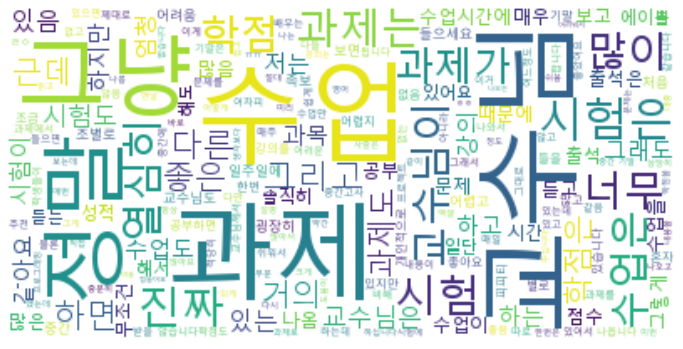

In [289]:
plt.figure(figsize=(12, 12))
wordcloud = WordCloud(
    font_path='/Windows/Fonts/malgun.ttf',
    background_color='white'
).generate(ece_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [301]:
wordcloud.words_

{'수업': 1.0,
 '교수님': 0.9814814814814815,
 '과제': 0.9351851851851852,
 '그냥': 0.6574074074074074,
 '정말': 0.6203703703703703,
 '시험은': 0.6111111111111112,
 '진짜': 0.5648148148148148,
 '시험': 0.5555555555555556,
 '과제는': 0.5,
 '너무': 0.48148148148148145,
 '교수님이': 0.4722222222222222,
 '열심히': 0.4722222222222222,
 '수업은': 0.4444444444444444,
 '많이': 0.4351851851851852,
 '학점': 0.4351851851851852,
 '과제가': 0.42592592592592593,
 '그리고': 0.4166666666666667,
 '하면': 0.37037037037037035,
 '다른': 0.3611111111111111,
 '좋은': 0.3425925925925926,
 '거의': 0.3055555555555556,
 '과제도': 0.3055555555555556,
 '학점은': 0.2962962962962963,
 '근데': 0.28703703703703703,
 '교수님은': 0.2777777777777778,
 '있는': 0.2777777777777778,
 '시험도': 0.26851851851851855,
 '있음': 0.26851851851851855,
 '그래도': 0.23148148148148148,
 '하고': 0.23148148148148148,
 '시험이': 0.23148148148148148,
 '같아요': 0.23148148148148148,
 '강의': 0.2222222222222222,
 '과목': 0.2222222222222222,
 '하는': 0.2222222222222222,
 '수업도': 0.2222222222222222,
 '하지만': 0.2222222222222222,
 '

In [304]:
ece_words = []
for review in df_review[4]:
    ece_words.append(review)

In [306]:
ece_words[0]

'도움은 많이 됬습니다. 숙제하면서 알게되는 내용이 많아요.'

In [309]:
from krwordrank.hangle import normalize

In [310]:
ece_words = [normalize(text, english=True, number=True) for text in ece_words]

In [368]:
wordrank_extractor = KRWordRank(
    min_count = 5, # 단어의 최소 출현 빈도수 (그래프 생성 시)
    max_length = 10, # 단어의 최대 길이
    verbose = True
    )

beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10

keywords, rank, graph = wordrank_extractor.extract(ece_words, beta, max_iter)

scan vocabs ... 
num vocabs = 2110
done = 10


In [369]:
for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
    print('%8s:\t%.4f' % (word, r))

      수업:	17.6859
      과제:	16.4272
     교수님:	14.7719
      시험:	11.3742
      정말:	6.2994
      그냥:	5.9577
      학점:	5.8447
      진짜:	5.5756
     열심히:	5.3064
      너무:	4.7723
      강의:	4.6439
      좋은:	4.4423
      다른:	4.2391
      중간:	4.1969
      많이:	4.1720
     그리고:	3.9507
      하면:	3.8958
      공부:	3.8538
      거의:	3.6104
      출석:	3.5233
      과목:	3.4775
      문제:	3.4279
      기말:	3.1825
      어렵:	2.9320
      하는:	2.9094
      있음:	2.8383
      근데:	2.6910
     하지만:	2.6611
      어려:	2.6317
      저는:	2.5423


In [370]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [371]:
wordcloud = wordcloud.generate_from_frequencies(keywords)

### 불용어 처리

In [372]:
stopwords = {'너무', '수업', '정말', '그냥', '진짜', '많이', '그리고',\
             '거의', '하는', '근데', '있음', '하지만', '저는', '교수님', '과제', '시험',\
            '학점', '좋은', '다른', '하면', }

for i in stopwords:
    keywords.pop(i)
wordcloud = WordCloud(stopwords=stopwords)
#wordcloud = wordcloud.generate_from_text(texts)

In [376]:
font_path = '/Windows/Fonts/malgun.ttf'

wordcloud = WordCloud(
    font_path = font_path,
    background_color=None,
    width = 1280,
    height = 720
)

wordcloud = wordcloud.generate_from_frequencies(keywords)

In [377]:
array = wordcloud.to_array()
print(type(array)) # numpy.ndarray
print(array.shape) # (800, 800, 3)

<class 'numpy.ndarray'>
(720, 1280, 3)


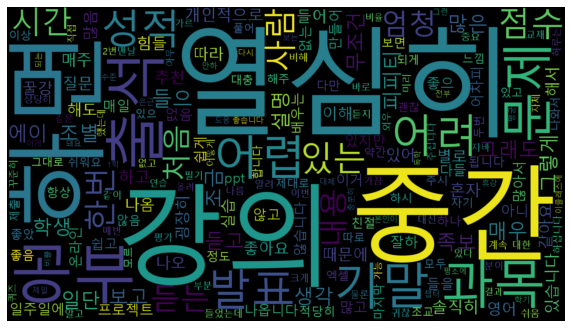

In [378]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation="bilinear")
plt.axis('off')
plt.show()
fig.savefig('wordcloud.png')